# Week 6 -- Multivariate OLS Regression


Let's use the dataset from last week to perform a multi-variate OLS Regression.

In [21]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='plotly_mimetype+notebook_connected'
from scipy import stats
import matplotlib.pyplot as plt 

## Q1: Regressors

Many of the variables available from the ```roster_with_score_2.csv``` file are categorical:

Attribute Name | Field Name | Type | Categorical | Restrictions | Description
--|--|--|--|--|--
Department |```department``` |```str``` | Yes |  | Departmental reporting structure
Location  |```location``` |```str``` | Yes | | Office Location
Age  |```age``` |```str``` | Yes | | Age by group of 10 years
Sex  |```sex``` |```str``` | Yes | | Sex
Employment Status  |```employment_status``` |```str``` | Yes | | Employment status (part time, full time)
Tenure  |```tenure``` |```str``` | Yes | | Tenure with the company in discrete increments

(a) For each categorical variable, create dummy variables that are suitable for use in an OLS regression (hint: please be careful to avoid multi-colinearity).

(b) Given the available regressors, would you keep all the categorical variables you identified above?

In [22]:
# Read data and drop unnamed fields
df = pd.read_csv('roster_with_score_2.csv')
df.drop([c for c in df.columns if c.startswith('Unnamed')], axis=1, inplace=True)
df.head(1)

,employee_id,title,last,first,manager_id,function,department,location,age,sex,...,tenure_id,seniority,alignment,development,enablement,engagement,leadership,overall,year_of_birth,time_on_the_job
0,343,CEO,Duran,Veronica,NaN,CEO,Leadership,"Mountain View, CA",35 - 44,F,...,2,4,0.8,0.666667,0.733333,0.68,0.733333,0.722667,1978,22.885246


In [23]:
# Convert categorical columns to category dtype and dummy-encode
categorical = ['department','age','location','sex','employment_status','tenure']
df[categorical] = df[categorical].astype('category')
dum_df = pd.get_dummies(df, columns=categorical)

# Review number of categories for each variable and remove last category of each variable to avoid co-linearity
for category in categorical:
    print(f'{len(df[category].cat.categories)} categories of {category}')
    dum_df.drop([c for c in dum_df.columns if c.startswith(category)][-1], axis=1, inplace=True)
    print(f'{len([c for c in dum_df.columns if c.startswith(category)])} dummy encoded column(s) for {category}')

36 categories of department
35 dummy encoded column(s) for department
6 categories of age
5 dummy encoded column(s) for age
5 categories of location
4 dummy encoded column(s) for location
2 categories of sex
1 dummy encoded column(s) for sex
2 categories of employment_status
1 dummy encoded column(s) for employment_status
5 categories of tenure
5 dummy encoded column(s) for tenure


In [24]:
# Review share of employees by department
grp = df.groupby('department', as_index=False)['employee_id'].count()
grp['pct'] = grp['employee_id'] / len(df)
grp.sort_values('employee_id', ascending=False).head()

,department,employee_id,pct
1,Algorithm Development,46,0.120735
13,Full Stack,41,0.107612
12,Front End,35,0.091864
31,Underwriting,30,0.078740
2,Back End,19,0.049869


### Category Analysis
Given that Department has 36 different categories, none of which account for a significant share of the population, it is unlikely to have explanatory power in a regression. We could include the top departments to test for significant, but even the top 5 fair to account for half of the population.

## Q2: Run Regressions and Assess Results

Let's keep the two regressors we added last week (time on the job, year of birth).  Run multivariate regressions and assess which regressors are significant.

(a) Run a "kitchen sink" model which includes all possible (or a large number of) regressors

(b) Which regressors are worth keeping and why?  Rerun the regression with the reduced complexity model.

(c) Inspect the residuals -- are they normally distributed?

(d) Compare the results of your regression to the results from last week.  If there is improvement in key metrics, is the increased complexity justified?  Which metric would you use to justify this?

In [25]:
# Assign numerical and dummy-encoded variables to a list for modeling
categorical2 = categorical.copy()
categorical2.remove('department')
variables = ['year_of_birth', 'time_on_the_job']
for category in categorical2:
    variables.extend([c for c in dum_df.columns if c.startswith(category)])
dum_df[variables].head(1)

,year_of_birth,time_on_the_job,age_18 - 24,age_25 - 34,age_35 - 44,age_45 - 54,age_55 - 64,"location_Atlanta, GA","location_Austin, TX","location_Chicago, IL","location_Mountain View, CA",sex_F,employment_status_Full time,tenure_id,tenure_1 to less than 2 years,tenure_2 to less than 4 years,tenure_4 to less than 6 years,tenure_6 months to less than 1 year
0,1978,22.885246,0,0,1,0,0,0,0,0,1,1,1,2,1,0,0,0


In [26]:
# Assign subset variables for model inputs
X = dum_df[variables]
X['intercept'] = 1
y = dum_df['overall']

# Run OLS model
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<ipython-input-26-cd1cc23c6827>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     16.72
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           4.32e-36
Time:                        21:53:42   Log-Likelihood:                 587.72
No. Observations:                 381   AIC:                            -1139.
Df Residuals:                     363   BIC:                            -1068.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
year_of_birth                           0.0008      0.001      0.805      0.421      -0.001       0.003
time_on_the_job                         0.0030      0.001      5.527      0.000       0.002       0.004
age_18 - 24                            -0.0037      0.053     -0.070      0.944      -0.108       0.101
age_25 - 34                             0.0078      0.046      0.171      0.865      -0.082       0.098
age_35 - 44                             0.0197      0.038      0.516      0.606      -0.055       0.095
age_45 - 54                             0.0111      0.032      0.341      0.734      -0.053       0.075
age_55 - 64                             0.0229      0.028      0.829      0.407      -0.031       0.077
location_Atlanta, GA                   -0.0685      0.026     -2.600      0.010      -0.120      -0.017
location_Austin, TX                    -0.0774      0.028     -2.789      0.006      -0.132      -0.023
location_Chicago, IL                   -0.0476      0.019     -2.477      0.014      -0.085      -0.010
location_Mountain View, CA              0.0365      0.008      4.835      0.000       0.022       0.051
sex_F                                  -0.0061      0.006     -1.025      0.306      -0.018       0.006
employment_status_Full time             0.0063      0.008      0.821      0.412      -0.009       0.022
tenure_id                              -0.0231      0.007     -3.374      0.001      -0.037      -0.010
tenure_1 to less than 2 years          -0.0149      0.007     -2.167      0.031      -0.028      -0.001
tenure_2 to less than 4 years          -0.0205      0.005     -4.089      0.000      -0.030      -0.011
tenure_4 to less than 6 years           0.0205      0.007      2.842      0.005       0.006       0.035
tenure_6 months to less than 1 year    -0.0136      0.011     -1.280      0.201      -0.035       0.007
intercept                              -0.8574      1.919     -0.447      0.655      -4.631       2.916
==============================================================================
Omnibus:                       14.424   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.485
Skew:                          -0.490   Prob(JB):                     0.000434
Kurtosis:                       2.879   Cond. No.                     1.24e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.72e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
fig = px.scatter(y=results.resid)
fig.show()

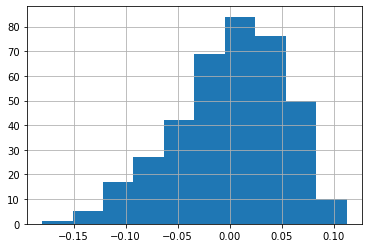

In [28]:
results.resid.hist();

### Kitchen Sink Model
Our `kitchen sink` model with nearly all regressors performed quite poorly, with an R<sup>2</sup> value of ~0.44. 
It appears that the following regressors had little to no predictive significance:
- Year of Birth
- Age
- Employment Status

For the next attempt, I will remove these values.

In [29]:
# Assign numerical and dummy-encoded variables to a list for modeling
categorical3 = categorical.copy()
categorical3 = list(set(categorical3) - {'department','age','employment_status'})
variables2 = ['time_on_the_job']
for category in categorical3:
    variables2.extend([c for c in dum_df.columns if c.startswith(category)])
dum_df[variables2].head(1)

,time_on_the_job,"location_Atlanta, GA","location_Austin, TX","location_Chicago, IL","location_Mountain View, CA",sex_F,tenure_id,tenure_1 to less than 2 years,tenure_2 to less than 4 years,tenure_4 to less than 6 years,tenure_6 months to less than 1 year
0,22.885246,0,0,0,1,1,2,1,0,0,0


In [30]:
# Assign subset variables for model inputs
X = dum_df[variables2]
X['intercept'] = 1
y = dum_df['overall']

# Run OLS model
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<ipython-input-30-8c30f12b0590>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     27.52
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           3.74e-39
Time:                        21:53:43   Log-Likelihood:                 583.49
No. Observations:                 381   AIC:                            -1145.
Df Residuals:                     370   BIC:                            -1102.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
time_on_the_job                         0.0030      0.001      5.524      0.000       0.002       0.004
location_Atlanta, GA                   -0.0781      0.025     -3.140      0.002      -0.127      -0.029
location_Austin, TX                    -0.0737      0.028     -2.666      0.008      -0.128      -0.019
location_Chicago, IL                   -0.0517      0.019     -2.712      0.007      -0.089      -0.014
location_Mountain View, CA              0.0371      0.007      4.952      0.000       0.022       0.052
sex_F                                  -0.0077      0.006     -1.333      0.183      -0.019       0.004
tenure_id                              -0.0224      0.007     -3.280      0.001      -0.036      -0.009
tenure_1 to less than 2 years          -0.0139      0.007     -2.020      0.044      -0.027      -0.000
tenure_2 to less than 4 years          -0.0215      0.005     -4.318      0.000      -0.031      -0.012
tenure_4 to less than 6 years           0.0206      0.007      2.866      0.004       0.006       0.035
tenure_6 months to less than 1 year    -0.0125      0.011     -1.185      0.237      -0.033       0.008
intercept                               0.7282      0.010     73.055      0.000       0.709       0.748
==============================================================================
Omnibus:                       14.594   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.634
Skew:                          -0.495   Prob(JB):                     0.000403
Kurtosis:                       2.947   Cond. No.                     2.70e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.14e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Reduced Complexity Model
The model with seemingly unimportant regressors removed actually performed slightly worse, with an R<sup>2</sup> value of 0.43. While this technically a decrease in model performance, the simpler nature of the model is likely to be worthwhile for explainability and ability to generalize to new data (avoids overfitting).

In [31]:
fig = px.scatter(y=results.resid)
fig.show()

<ipython-input-32-7741cb832584>:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



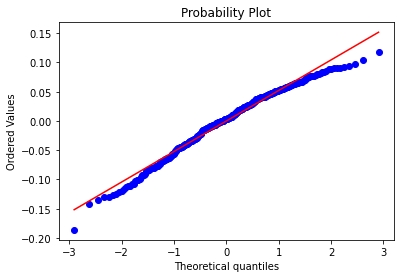

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(results.resid, dist='norm', plot=ax)
fig.show()

### Residuals
The residuals from both the `kitchen sink` and `simplified` models appear to be generally normally distributed, meaning we are unlikely to have missed a critical explanatory variable in our analysis.

### Comparison to Univariate
Both multivariate models performed significantly better than the single-variable regression performed last week, which only achieved an R<sup>2</sup> of 0.22 for the best performing category.

In [33]:
px.box(df, x='tenure', y='overall')

In [34]:
px.box(df, x='location', y='overall')

## Q3: Other Regressors

If you had unlimited programming skills, what other regressors would you create from the available data?
- Common approaches to create more accurate regression models include log transformation and polynomial expansion of existing features. Log transformation can help the model interpret the data more consistently, while strategies like polynomial expansion can create new features altogether. This can be combined with optimization of feature importance to create a very accurate model, but it often is at the cost of explainability, as the features may no longer resemble the original variables in the data.

Describe how your interpretations of the regression can help inform business decisions.
- Identifying the most significant variables in determining overall employee satisfaction can help the company to understand where to focus their time and energy to promote satisfaction. For example, the strongest regressors were tenure and location. Because increased tenure is associated with increased satisfaction, the company could consider investing in retention programs to incentive and encourage employees to stay. As discussed in prior assignments, it is important to also consider the reverse causal relationship, that high satisfaction increases tenure because satisfied employees are less likely to leave. By identifying an association between location and satisfaction, the company could examine the practices of high-performing offices to replicate their success or focus hiring in areas where employees are generally satisfied.

In [20]:
!jupyter nbconvert --to html --template full *.ipynb

[NbConvertApp] Converting notebook Loantronic_MultiRegression.ipynb to html
C:\Users\mconan002\Anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 408444 bytes to Loantronic_MultiRegression.html
